<a href="https://colab.research.google.com/github/Aniketnegi03/signal-classification-using-CNN/blob/main/2_signal_classification_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/signal_cnn/primary_small')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)

import warnings;warnings.simplefilter('ignore')
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing import image_dataset_from_directory
%matplotlib inline
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.2


In [ ]:
ls

tensorflow_hub/  test/  train/  valid/


In [ ]:
train_path="/content/drive/MyDrive/signal_cnn/primary_small/train"
test_path="/content/drive/MyDrive/signal_cnn/primary_small/test"
val_path="/content/drive/MyDrive/signal_cnn/primary_small/valid"

classes_list = sorted(os.listdir(train_path))
classes_list

['brightpixel',
 'narrowband',
 'narrowbanddrd',
 'noise',
 'squarepulsednarrowband',
 'squiggle',
 'squigglesquarepulsednarrowband']

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (224, 224)
IMAGE_SHAPE = (240, 240)
BATCH_SIZE = 32

train_path="/content/drive/MyDrive/signal_cnn/primary_small/train"
test_path="/content/drive/MyDrive/signal_cnn/primary_small/test"
val_path="/content/drive/MyDrive/signal_cnn/primary_small/valid"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_ds = train_datagen.flow_from_directory(train_path,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_ds = train_datagen.flow_from_directory(test_path,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 5600 images belonging to 7 classes.
Testing images:
Found 700 images belonging to 7 classes.


In [ ]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:

efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/classification/2"


## EFFICIENTNET_V2 B1 MODEL

In [ ]:

def create_model(model_url, num_classes=10):

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=True, # Un-freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) 
  
 
  model = tf.keras.Sequential([
    feature_extractor_layer, 
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [ ]:

efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB1 TensorFlow Hub URL
                                  num_classes=train_ds.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_ds, 
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_ds),
                                              validation_data=test_ds,
                                              validation_steps=len(test_ds),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",                                                                                     
                                                                                     experiment_name="efficientnetB1")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220614-111059
Epoch 1/5
175/175 [==============================] - 1612s 9s/step - loss: 1.1371 - accuracy: 0.6348 - val_loss: 1.2709 - val_accuracy: 0.6043
Epoch 2/5
175/175 [==============================] - 1544s 9s/step - loss: 0.7923 - accuracy: 0.7711 - val_loss: 1.0020 - val_accuracy: 0.6843
Epoch 3/5
175/175 [==============================] - 1582s 9s/step - loss: 0.6751 - accuracy: 0.8195 - val_loss: 0.7963 - val_accuracy: 0.7714
Epoch 4/5
175/175 [==============================] - 1674s 10s/step - loss: 0.5696 - accuracy: 0.8573 - val_loss: 0.9780 - val_accuracy: 0.8000
Epoch 5/5
175/175 [==============================] - 1684s 10s/step - loss: 0.4983 - accuracy: 0.8777 - val_loss: 0.8003 - val_accuracy: 0.8043


In [ ]:
efficientnet_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 4,058,531
Trainable params: 4,016,515
Non-trainable params: 42,016
_________________________________________________________________


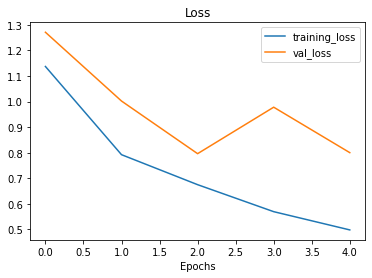

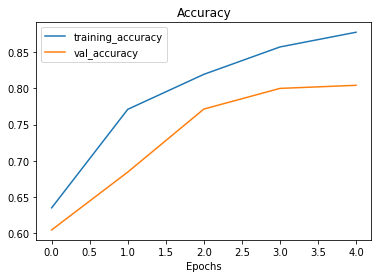

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.evaluate(test_ds)

22/22 [==============================] - 44s 2s/step - loss: 0.8003 - accuracy: 0.8043


[0.8003010153770447, 0.8042857050895691]